# Aggregate Busch grid data by oil palm concessions
populates: "outputs/features_by_oilpalm_concession.csv"

- does same exact thing as features.ipynb (code was directly copied) but is slightly altered to work with the oilpalm dataset

- each row represents an oil plam concession and the columns are different features and covariates

note: takes forever to run to completion due to the sheer number of oil palm concessions there are (13k+)

In [1]:
# imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import descartes
from shapely.geometry import Point, Polygon


In [2]:
indonesia = gpd.read_file("data/indonesia_boundary.json")
concessions = gpd.read_file("data/Greenpeace_Indonesia_Oil_Palm_Concessions_Map_Nov_2020.shp")
grid = pd.read_csv("data/land_features_cells.csv")


# mock data
# concessions = gpd.read_file("mock/mock_concessions.geojson")
# grid = pd.read_csv("mock/mock_grid.csv")

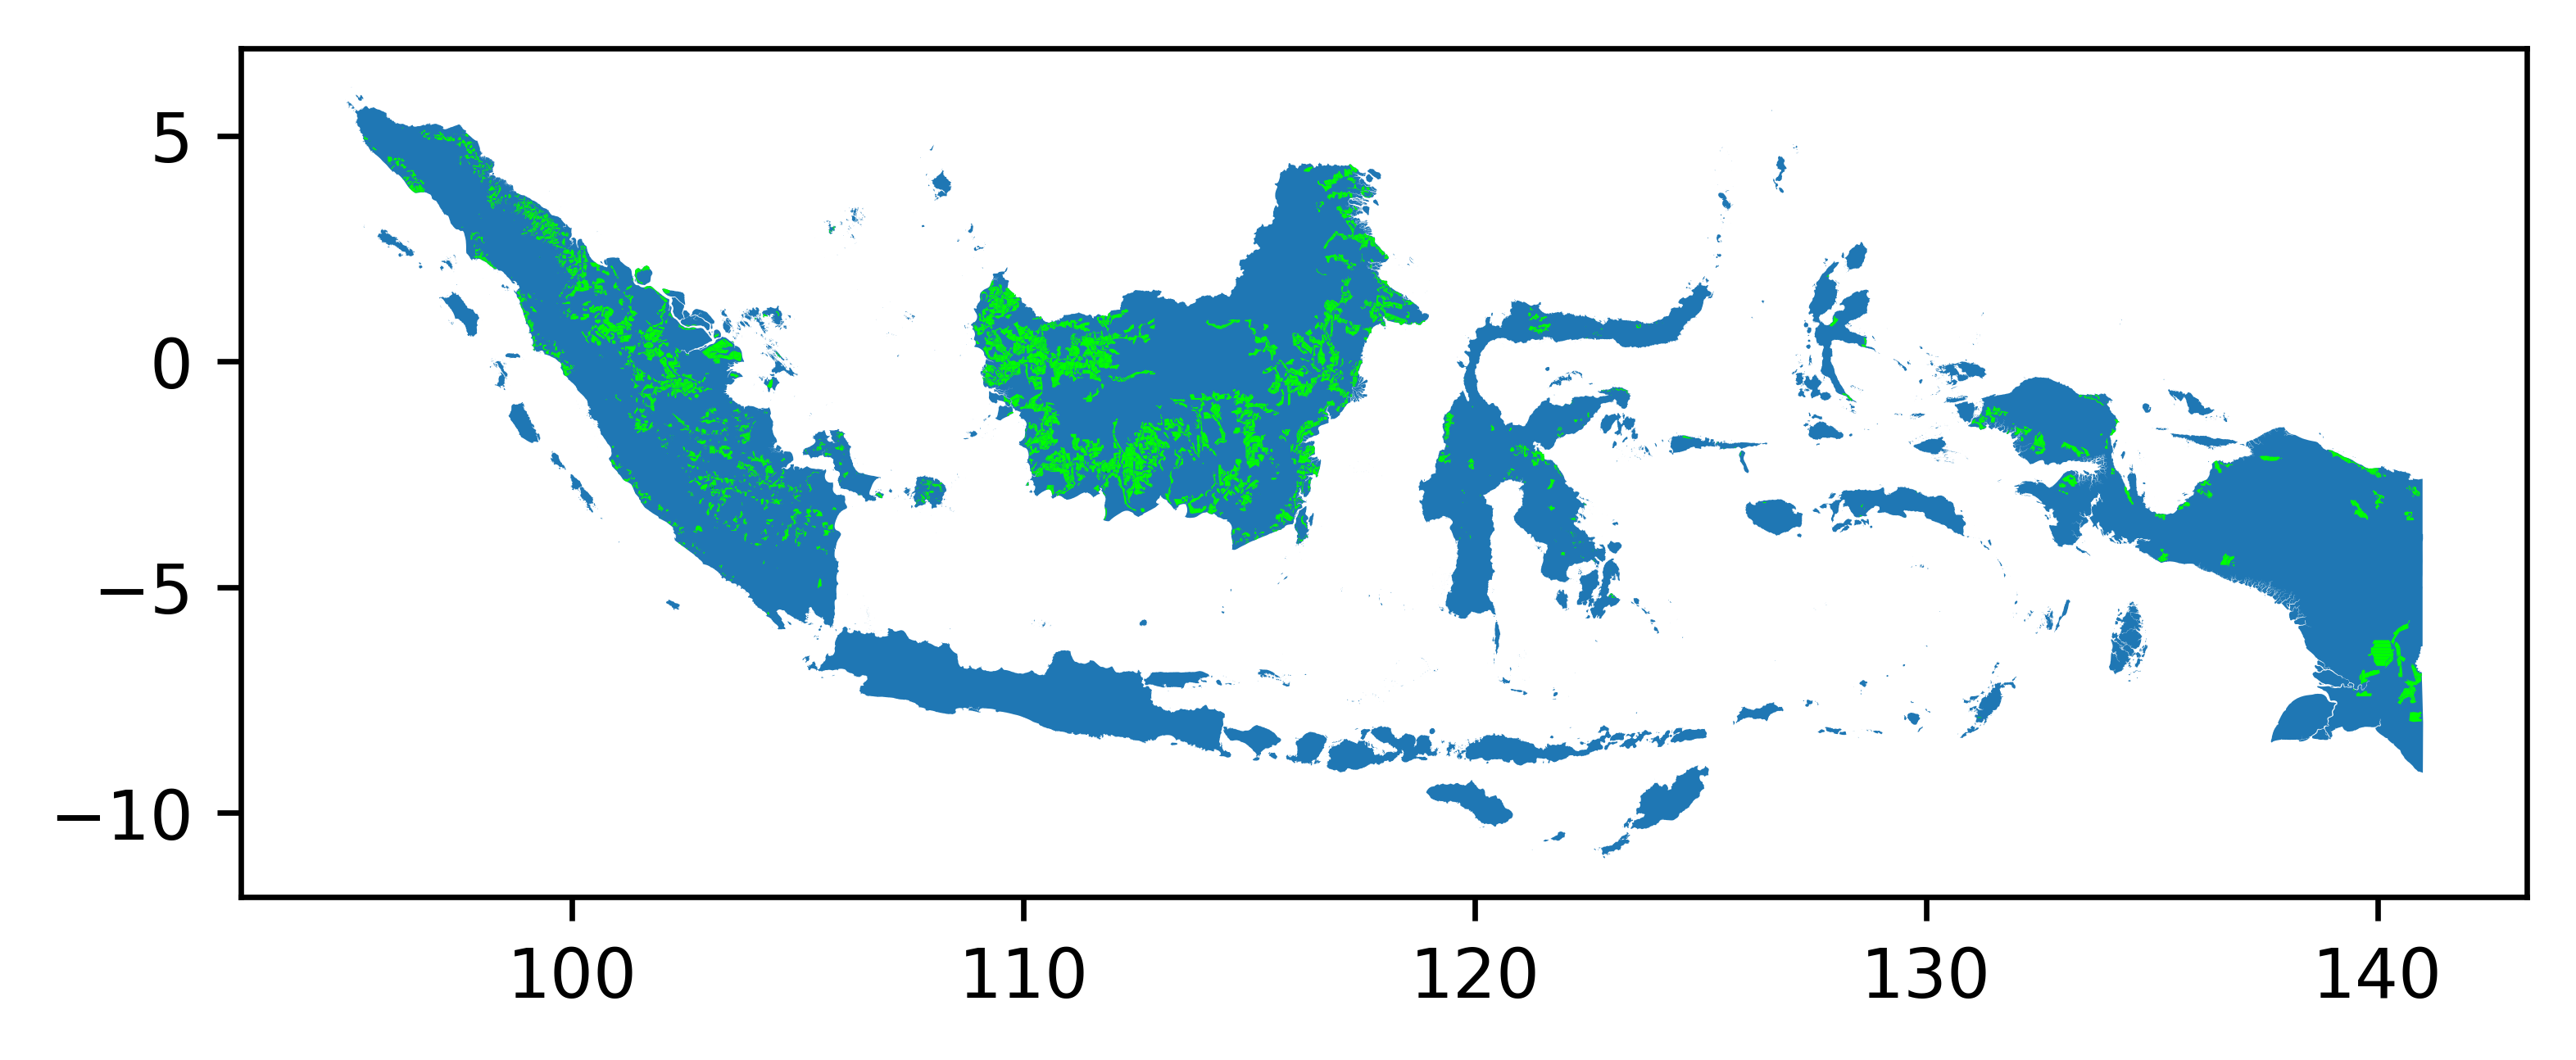

In [3]:
mpl.rcParams['figure.dpi'] = 600 # set dpi
fig = plt.figure()
ax = plt.subplot(111)

indonesia.plot(ax=ax)
concessions.plot(color="lime", ax=ax)

# grid.plot.scatter(x='geo_x', y='geo_y', s=4, ax=ax, color="red")
plt.axis('scaled')

# concessions['coords'] = concessions['geometry'].apply(lambda x: x.representative_point().coords[:])
# concessions['coords'] = [coords[0] for coords in concessions['coords']]
# for idx, row in concessions.iterrows():
#     plt.annotate(text=concessions.index[idx], xy=row['coords'],
#                  horizontalalignment='center', fontsize=1.5)

# concessions.plot()

# # label grid
# for idx, row in grid.iterrows():
#     plt.annotate(text=grid['id'][idx], xy=(row['geo_x'], row['geo_y']),
#                  horizontalalignment='center', fontsize=15)

plt.show()


In [4]:
# conversions: https://stackoverflow.com/questions/1253499/simple-calculations-for-working-with-lat-lon-and-km-distance#:~:text=The%20approximate%20conversions%20are%3A,111.320*cos(latitude)%20km
# geo_x	longitude; higher is eastward
# geo_y	latitude; higher is northward
# 3 km longitutde = 3 / (111.320*cos(latitude)) deg
# 3 km latitude = 3 / 110.574 deg

coords = [] # Point object of given geo_x, geo_y
cell_bounds = [] # Polygon of cell bounds using coord as center
for i in range(len(grid)):
    x, y = grid['geo_x'][i], grid['geo_y'][i]
    dx, dy = 3/(111.320*np.cos(np.deg2rad(y))), 3/110.574
    # dx, dy = 2, 2

    coords.append(Point(x, y))    
    cell_bounds.append(Polygon([(x-dx/2, y-dy/2), (x-dx/2, y+dy/2), (x+dx/2, y+dy/2), (x+dx/2, y-dy/2)]))

grid['coord'] = coords
grid['cell_bounds'] = cell_bounds
grid.head()

,id,cellcode,geo_x,geo_y,area,slope,elev,distroad,distcapital,biomasscarbonruesch,...,defor2002,defor2003,defor2004,defor2005,defor2006,defor2007,defor2008,defor2009,coord,cell_bounds
0,1,100001,111.1630,-8.2789,476.0,7.88374,141.1430,7.62500,90.1111,74.7,...,0.00,0.18,0.00,2.52,0.18,2.34,0.00,0.09,POINT (111.163 -8.2789),POLYGON ((111.1493834325356 -8.292465575994356...
1,2,100004,111.0193,-8.2518,530.0,4.55512,95.0417,5.00000,76.4167,30.0,...,1.08,0.45,0.00,1.17,0.00,2.34,0.90,1.71,POINT (111.0193 -8.251799999999999),POLYGON ((111.0056843680819 -8.265365575994355...
2,3,100005,111.0465,-8.2518,480.0,5.06259,150.3750,2.27778,78.7222,77.0,...,2.52,0.36,0.18,2.25,0.09,1.35,1.35,0.00,POINT (111.0465 -8.251799999999999),POLYGON ((111.0328843680819 -8.265365575994355...
3,4,100006,111.0737,-8.2518,179.0,2.85966,135.2860,1.00000,81.1111,37.3,...,0.09,0.09,1.08,0.00,0.00,0.00,0.27,0.09,POINT (111.0737 -8.251799999999999),POLYGON ((111.0600843680819 -8.265365575994355...
4,5,100008,111.1282,-8.2518,797.0,10.38430,200.3530,4.90323,85.8889,169.0,...,0.27,0.72,0.27,2.43,0.27,1.71,0.36,1.08,POINT (111.1282 -8.251799999999999),POLYGON ((111.1145843680819 -8.265365575994355...


In [5]:
grid.rename(columns={' defor2000 ': 'defor2000'}, inplace=True)


In [6]:
# populate concessions_with_grid and pts_inside_conc
# brute force until coming up with smarter way....problem is the grid is so irregular....
# thought about using nearest neighbors + minimum bounding boxes and structures for that but the grid is just hard to work with in an organized way...
concession_cells = set()
cells_per_concession = [[] for i in range(len(concessions))] # each list contains the index of the cells which are contained in it
cells_proportions_per_concession = [[] for i in range(len(concessions))] # each list contains the proportion of the area covered by the contained cells in the concession
cells_areas_per_concession =  [[] for i in range(len(concessions))] # each list contains the area covered by the contained cells in the concession
for i in range(len(grid)):
    cell = grid['cell_bounds'][i] # Polygon
    j = 0
    for concession in concessions['geometry']:
        if concession.intersects(cell):
            # calculate intersection & proportion 
            intersection = cell.intersection(concession).area
            if intersection > 0:
                concession_cells.add(i)
                cells_per_concession[j].append(i)
                cells_areas_per_concession[j].append(intersection)
                cells_proportions_per_concession[j].append(intersection / cell.area)
        j += 1

In [38]:
len(cells_per_concession)

12259

In [12]:
# tmpfile = open('outputs/tmp/concession_cells.csv')
tmp_df = pd.DataFrame(list(concession_cells), columns=["concession_cells"])
tmp_df.to_csv('outputs/tmp/concession_cells.csv', index=False)

In [7]:
print(len(concession_cells))

36001


In [8]:
# print(cells_per_concession)
# print(cells_areas_per_concession)
# print(cells_proportions_per_concession)

In [8]:
total_area_per_concession_from_cell = np.array([sum(ls) for ls in cells_areas_per_concession])
total_area_per_concession_from_shape = np.array([shape.area for shape in concessions['geometry']])
cells_vs_shape_areas = total_area_per_concession_from_cell/total_area_per_concession_from_shape
insufficient_data_25 = [i for i in range(len(cells_vs_shape_areas)) if cells_vs_shape_areas[i] < .25]
insufficient_data_50 = [i for i in range(len(cells_vs_shape_areas)) if cells_vs_shape_areas[i] > .25 and cells_vs_shape_areas[i] < .5]

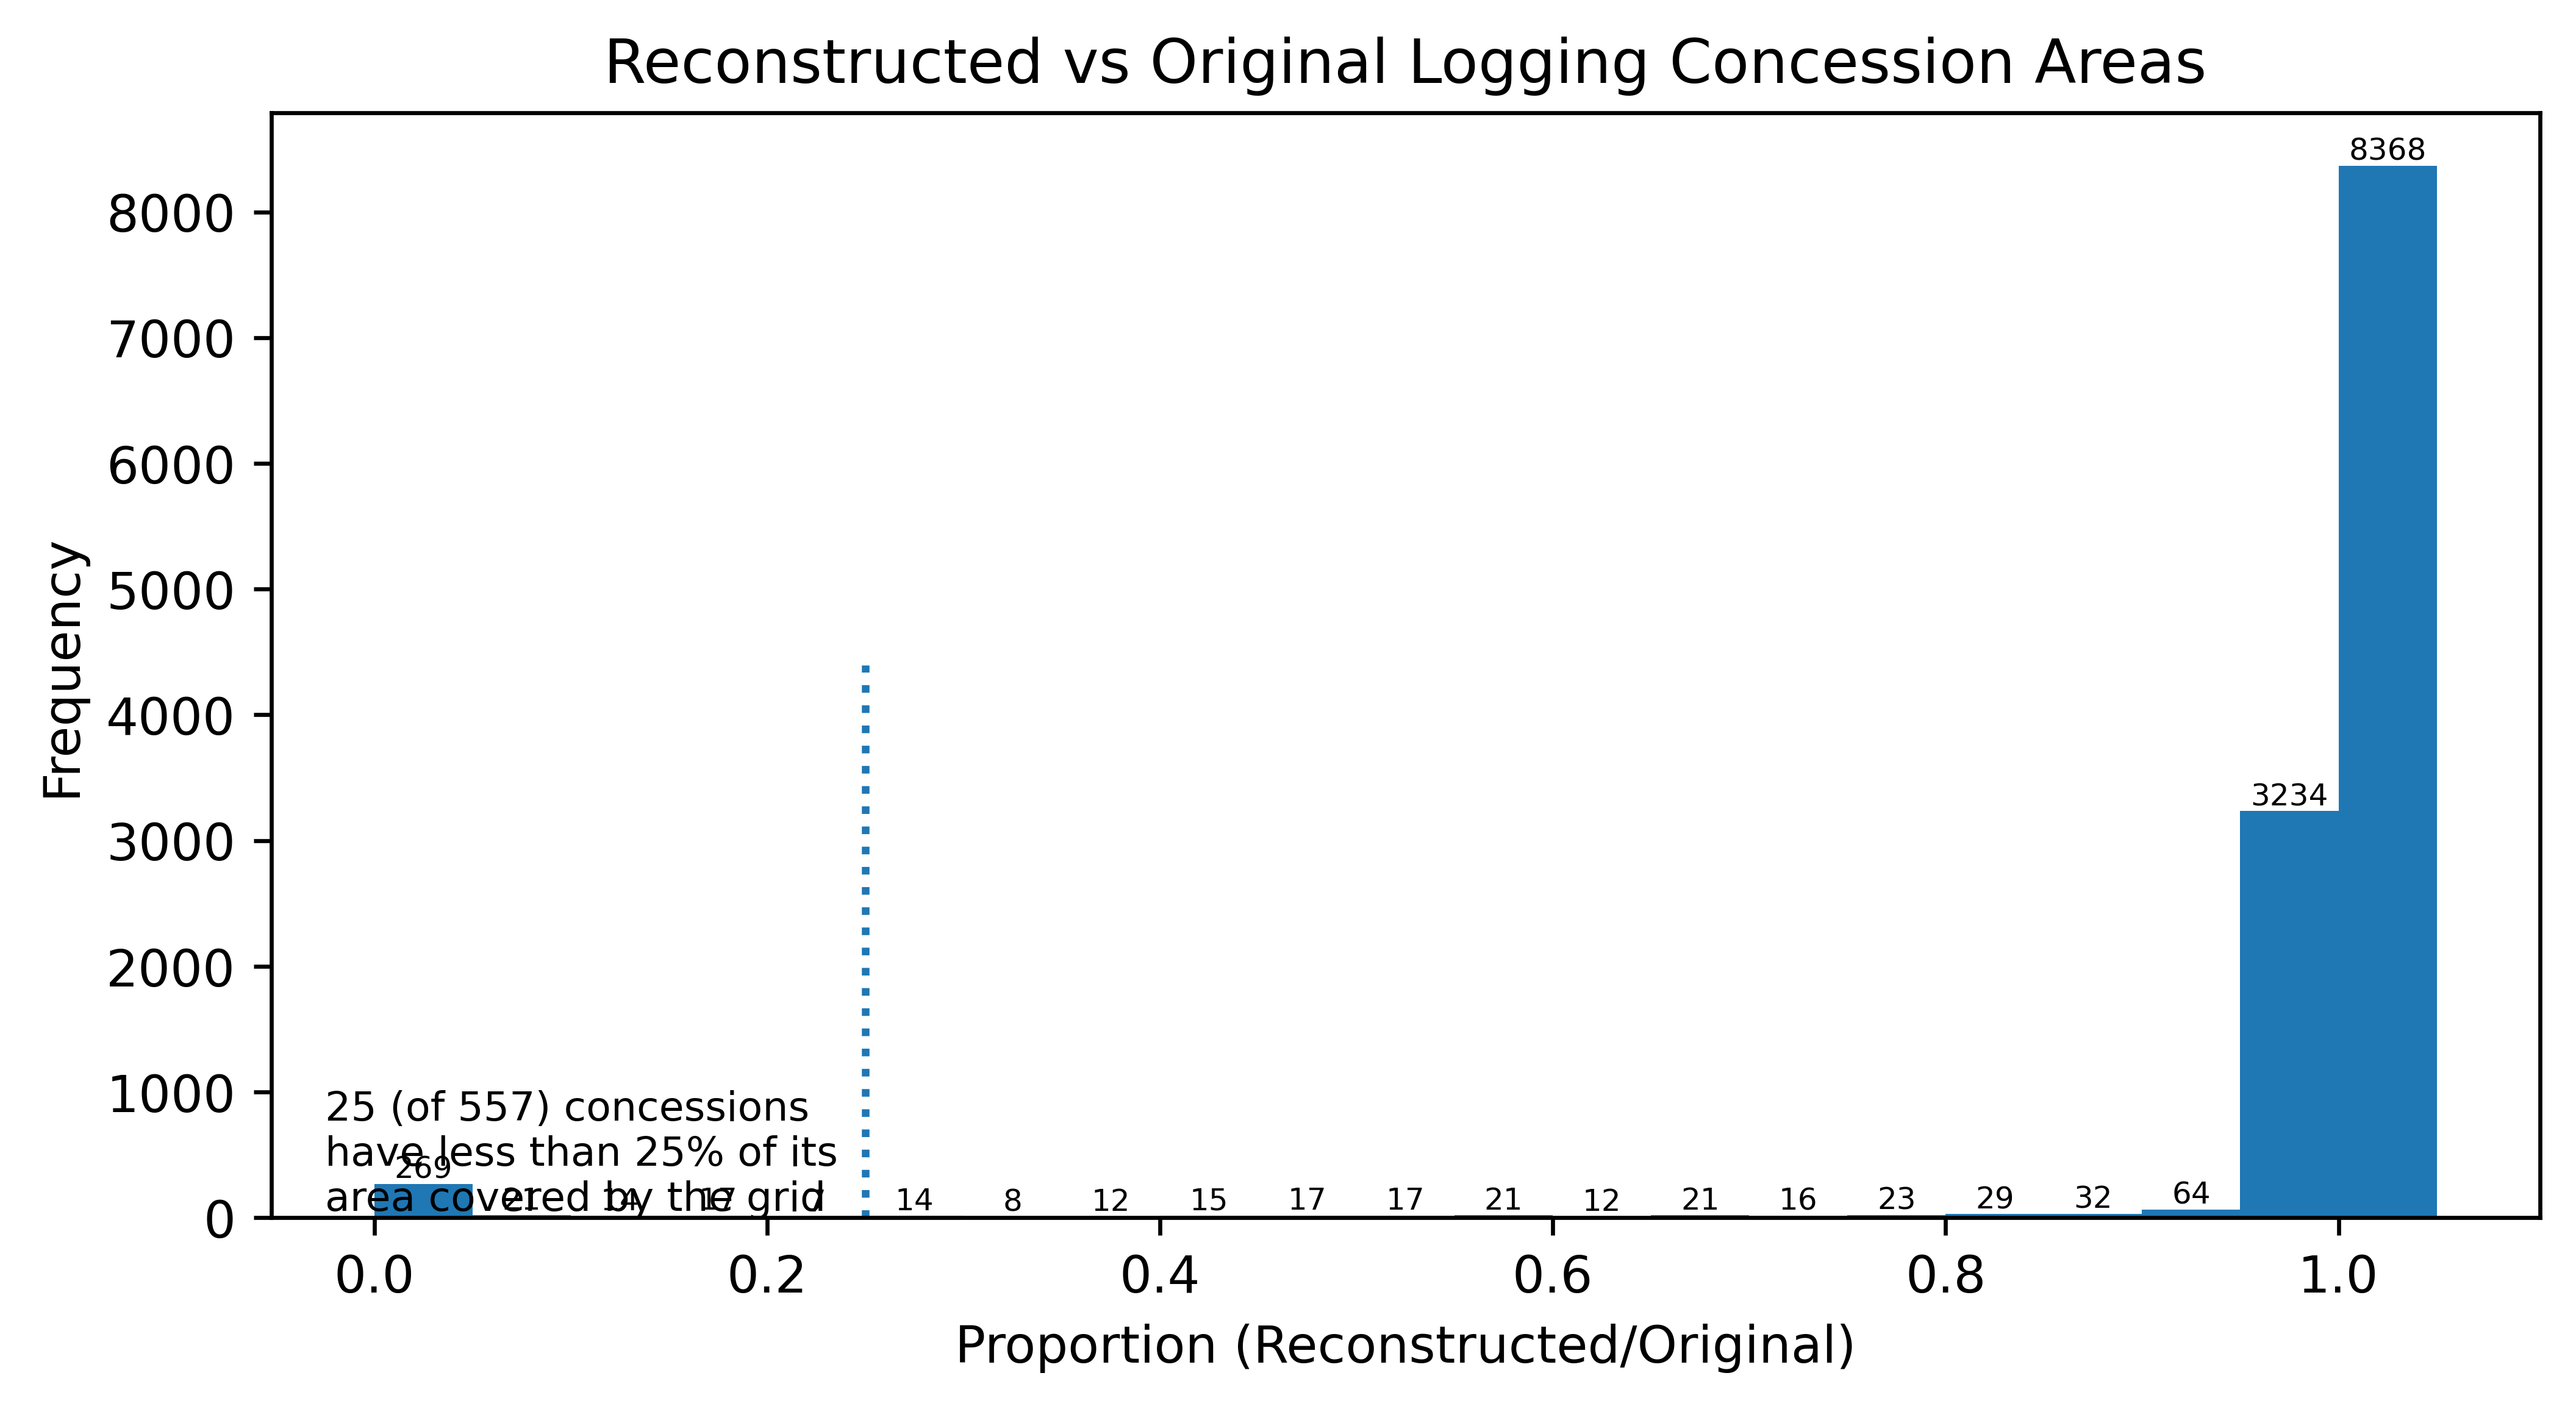

In [9]:
fig, ax = plt.subplots(figsize = (8,4))

plt.hist(cells_vs_shape_areas, bins=np.arange(0, 1.1, .05))
for c in ax.containers:
    ax.bar_label(c, size=6)
ax.axvline(.25, ymax = .5, linestyle = ":")
plt.title("Reconstructed vs Original Logging Concession Areas")
plt.xlabel("Proportion (Reconstructed/Original)")
plt.ylabel("Frequency")
# plt.text(s = "25 (of 557) concessions \nhave less than 25% of its \narea covered by the grid", x=-.025, y=60, size=8)
plt.show()

In [15]:
# populate all data per concession

fields = ['id', 'area', 'slope','elev', 'distroad', 'distcapital', 'peatdepth', 'biomasscarbonruesch', 'soilcarbon', 'biomasscarbonbaccini', 
    'defor2000', 'defor2001','defor2002','defor2003','defor2004','defor2005','defor2006', 'defor2007','defor2008','defor2009']#,
    # 'slope_std', 'elev_std', 'distroad_std', 'distcapital_std', 'biomasscarbonruesch_std', 'soilcarbon_std', 'peatdepth_std', 'biomasscarbonbaccini_std']
fields_dict = {key:[] for key in fields}
num_concessions = len(concessions)


# plain avg
def average_by_cell(key):
    """
    in-place modification/population of fields_dict
    for keys: slope, elev, distroad, distcapital, peatdepth
    """
    for i in range(num_concessions):
        if i in insufficient_data_25:
            fields_dict[key].append(float("NaN"))
        else:
            # print(i)
            cells_contained = cells_per_concession[i]
            # print([grid.iloc[cell, :][key] for cell in cells_contained])
            fields_dict[key].append(np.average([grid.iloc[cell, :][key] for cell in cells_contained]))
            # print(fields_dict[key][-1])

        # do std dev
        # fields_dict[key+"_std"].append(np.std([grid.iloc[cell][key] for cell in cells_contained]))

# area based avg
def average_by_cell_areas(key):
    """
    in-place modification/population of fields_dict
    for keys: biomasscarbonruesch, biomasscarbonbaccini, soilcarbon
    """
    for i in range(num_concessions):
        if i in insufficient_data_25:
            fields_dict[key].append(float("NaN"))
        else:
            cells_contained = cells_per_concession[i]
            areas = cells_areas_per_concession[i]
            proportions = cells_proportions_per_concession[i]
            # print("prop", proportions)
            # print("cell", list(grid.iloc[cells_contained, :][key]))

            proportional_qtys = []
            # total_area = concessions['area'][i] # given
            total_area = sum(areas) # calculuated - should be equiv to ^ 
            for i in range(len(cells_contained)):
                proportional_qtys.append(proportions[i] * grid.iloc[cells_contained[i], :][key])
            # print("qtys", proportional_qtys)
            # print(sum(proportional_qtys), total_area)

            fields_dict[key].append(sum(proportional_qtys)/total_area)

            
        # do std dev (just using attributes from all intersecting cells)
        # fields_dict[key+"_std"].append(np.std([grid.iloc[cell][key] for cell in cells_contained]))

# summing, also doing interpolation
def sum_by_cell_areas(key):
    """
    in-place modification/population of fields_dict
    for keys: all defor200X
    """
    for i in range(num_concessions):
        if i in insufficient_data_25:
            fields_dict[key].append(float("NaN"))
        else:
            cells_contained = cells_per_concession[i]
            areas = cells_areas_per_concession[i]
            proportions = cells_proportions_per_concession[i]
            # print("prop", proportions)
            # print("cell", list(grid.iloc[cells_contained, :][key]))

            proportional_qtys = []
            given_area = concessions['geometry'][i].area # given
            recon_area = sum(areas) # reconstructed/calculuated area - should be (close to) equiv to ^ 
            for i in range(len(cells_contained)):
                proportional_qtys.append(proportions[i] * grid.iloc[cells_contained[i], :][key])
            # print("qtys", proportional_qtys)
            # print(sum(proportional_qtys), total_area)

            # do area corrrection
            total = sum(proportional_qtys) / recon_area * given_area

            fields_dict[key].append(total)

# populate fields
fields_dict['id'] = [i for i in range(1, num_concessions+1)]
fields_dict['area'] = [concessions['AREA'][i] for i in range(num_concessions)]
# fields_dict['year'] = [concessions['year'][i] for i in range(num_concessions)]

for field in fields[3:8]:
    # 'slope','elev', 'distroad', 'distcapital', 'peatdepth'
    print("averaging FIELD:", field)
    average_by_cell(field)

for field in fields[8:11]:
    # 'biomasscarbonruesch', 'soilcarbon', 'biomasscarbonbaccini'
    print("averaging by area FIELD:", field)
    average_by_cell_areas(field)

for field in fields[11:21]:
    # 'defor2000', 'defor2001','defor2002','defor2003','defor2004','defor2005','defor2006', 'defor2007','defor2008','defor2009'
    print("summing FIELD:", field)
    sum_by_cell_areas(field)




averaging FIELD: elev
averaging FIELD: distroad
averaging FIELD: distcapital
averaging FIELD: peatdepth
averaging FIELD: biomasscarbonruesch
averaging by area FIELD: soilcarbon
averaging by area FIELD: biomasscarbonbaccini
averaging by area FIELD: defor2000
summing FIELD: defor2001
summing FIELD: defor2002
summing FIELD: defor2003
summing FIELD: defor2004
summing FIELD: defor2005
summing FIELD: defor2006
summing FIELD: defor2007
summing FIELD: defor2008
summing FIELD: defor2009


In [35]:
fields_dict['slope'] = []
average_by_cell('slope') # somehow this didnt make it in from the cell above, 
    # probs an indexing error in 'for field in fields[3:8]:'


In [16]:
fields_dict['area']

[1399088.83572,
 125065.997521,
 376990.640294,
 23626623.2813,
 51036537.1555,
 22742352.6596,
 25485163.2722,
 21484519.7569,
 191835994.102,
 6391536.30588,
 151386718.255,
 45030677.8628,
 25121711.8824,
 20940165.3645,
 4571734.11256,
 4016633.61235,
 5745448.18274,
 6048012.74513,
 24110662.4084,
 6598.39331671,
 26568.3043033,
 12556.7094505,
 1922526.55816,
 3333867.56544,
 17217070.9088,
 10232070.595,
 72744950.5365,
 78484865.0097,
 99558501.539,
 146063917.562,
 47508046.6158,
 31799271.6111,
 81338441.2093,
 34069823.6213,
 2427687.63354,
 73298573.0882,
 62286092.6311,
 126273518.467,
 49917187.755,
 3842908.39393,
 196420636.695,
 8381781.86284,
 31206651.9543,
 90496383.0943,
 44111520.8504,
 7837266.49951,
 14916816.3167,
 81853241.3412,
 131714901.958,
 138411823.002,
 13854219.2657,
 16264348.488,
 1965703.88096,
 1702129.05011,
 3197176.79943,
 6320475.81031,
 396213.921753,
 934949.576762,
 218125.487924,
 10460578.6959,
 220132345.821,
 102861028.768,
 55918292.80

In [17]:
# do proportions
for field in fields[11:21]:
    print("FIELD: prop", field)
    # print(fields_dict[field][i],fields_dict['area'][i])

    fields_dict[field+"prop"] = []
    for i in range(len(fields_dict[field])): # for every concession
        if float(fields_dict['area'][i]) == 0: # NaN if concession area is 0 
            fields_dict[field+"prop"].append( float("NaN") )
        else: # take proportion = value/area
            fields_dict[field+"prop"].append( fields_dict[field][i] / float(fields_dict['area'][i]) )
    print(len(fields_dict[field+"prop"])) # sanity check


fields_dict["num_cells"] = [len(ls) for ls in cells_per_concession]




FIELD: prop defor2001
12259
FIELD: prop defor2002
12259
FIELD: prop defor2003
12259
FIELD: prop defor2004
12259
FIELD: prop defor2005
12259
FIELD: prop defor2006
12259
FIELD: prop defor2007
12259
FIELD: prop defor2008
12259
FIELD: prop defor2009
12259


In [19]:
# cumulative deforestation up to 2009
# calculated by summing from the year the concession was introduced through 2009
# do proportions
fields_dict['defor_cumul'] = []
fields_dict['defor_cumul_avg'] = []
for i in range(len(fields_dict['defor2000'])):
    # print(i)
    conc_year = 1999 # just take all years bc years of OP concessions existence is unknown # fields_dict['year'][i] # 
    # print(conc_year)
    cumul_defor = sum([fields_dict[field][i] for field in fields[11:21] if int(field[-4:]) >= int(conc_year)])
    fields_dict['defor_cumul'].append(cumul_defor)

# cumulative proportion of deforestation - make this a proportion
fields_dict['defor_cumul_prop'] = [fields_dict['defor_cumul'][i]/float(fields_dict['area'][i]) if float(fields_dict['area'][i]) > 0 else np.NaN for i in range(len(fields_dict['defor_cumul']))]

# [f(x) if condition else g(x) for x in sequence]

    

In [21]:
# avg cumul deforestation up to 2009
# calculated by summing from the year the concession was introduced through 2009
# do proportions
fields_dict['defor_cumul_avg'] = []
for i in range(len(fields_dict['defor2000'])):
    # print(i)
    conc_year = 1999 # just take all years bc years of OP concessions existence is unknown # fields_dict['year'][i] # 
    # print(conc_year)
    cumul_defor_avg = np.mean([fields_dict[field][i] for field in fields[11:21] if int(field[-4:]) >= int(conc_year)])
    fields_dict['defor_cumul_avg'].append(cumul_defor_avg)

# cumulative proportion of deforestation - make this a proportion
fields_dict['defor_cumul_prop_avg'] = [fields_dict['defor_cumul_avg'][i]/float(fields_dict['area'][i]) if float(fields_dict['area'][i]) > 0 else np.NaN for i in range(len(fields_dict['defor_cumul_avg']))]

# [f(x) if condition else g(x) for x in sequence]

    

In [22]:
for i, field in enumerate(fields_dict):
    if i > 10:
        print (i, field)

11 defor2001
12 defor2002
13 defor2003
14 defor2004
15 defor2005
16 defor2006
17 defor2007
18 defor2008
19 defor2009
20 defor2001prop
21 defor2002prop
22 defor2003prop
23 defor2004prop
24 defor2005prop
25 defor2006prop
26 defor2007prop
27 defor2008prop
28 defor2009prop
29 num_cells
30 defor_cumul
31 defor_cumul_avg
32 defor_cumul_prop
33 defor_cumul_prop_avg


In [25]:
for field in list(fields_dict.keys())[21:31]:
    print("FIELD:", field)
    median = np.nanmedian(fields_dict[field])
    curr_year = field[5:9]
    # NEED TO FIX THIS
    fields_dict[field+"over_50p"] = [1 if (val >= median) else 0 for val in fields_dict[field]]
    # print(len(fields_dict[field+"over_50p"])) # sanity check
# should i do median of all or just median of active concessions

fields_dict["count_over_50p"] = np.array([0 for _ in range(557)])
for i, field in enumerate(fields_dict):
    if i in np.arange(36, 45):
        # print(fields_dict["count_over_50p"])
        print (i, field)
        fields_dict["count_over_50p"] += np.array(fields_dict[field])
        #print(fields_dict["count_over_50p"])

# years the concession is in effect during 2001 and 2009
# fields_dict["years_in_effect"] = 2010 - np.array([max(int(yr), 2000) for yr in concessions["year"]])
# standardize the count over the # years the concession was in effect
# fields_dict["over_50p_normed"] = np.array(fields_dict["count_over_50p"]) / fields_dict["years_in_effect"]


FIELD: defor2002prop
FIELD: defor2003prop
FIELD: defor2004prop
FIELD: defor2005prop
FIELD: defor2006prop
FIELD: defor2007prop
FIELD: defor2008prop
FIELD: defor2009prop
FIELD: num_cells
FIELD: defor_cumul
36 defor2004propover_50p


ValueError: operands could not be broadcast together with shapes (557,) (12259,) (557,) 

12259

In [43]:
fields_dict["cells_per_concession"] = cells_per_concession
fields_dict["cells_areas_per_concession"] = cells_areas_per_concession
fields_dict["cells_proportions_per_concession"] = cells_proportions_per_concession

In [44]:
for i in fields_dict:
    print(i, len(fields_dict[i]))
features_df = pd.DataFrame.from_dict(fields_dict)
features_df

id 12259
area 12259
elev 12259
distroad 12259
distcapital 12259
peatdepth 12259
biomasscarbonruesch 12259
soilcarbon 12259
biomasscarbonbaccini 12259
defor2000 12259
defor2001 12259
defor2002 12259
defor2003 12259
defor2004 12259
defor2005 12259
defor2006 12259
defor2007 12259
defor2008 12259
defor2009 12259
defor2001prop 12259
defor2002prop 12259
defor2003prop 12259
defor2004prop 12259
defor2005prop 12259
defor2006prop 12259
defor2007prop 12259
defor2008prop 12259
defor2009prop 12259
num_cells 12259
defor_cumul 12259
defor_cumul_avg 12259
defor_cumul_prop 12259
defor_cumul_prop_avg 12259
defor2002propover_50p 12259
defor2003propover_50p 12259
defor2004propover_50p 12259
defor2005propover_50p 12259
defor2006propover_50p 12259
defor2007propover_50p 12259
defor2008propover_50p 12259
defor2009propover_50p 12259
num_cellsover_50p 12259
defor_cumulover_50p 12259
slope 12259
cells_per_concession 12259
cells_areas_per_concession 12259
cells_proportions_per_concession 12259


,id,area,elev,distroad,distcapital,peatdepth,biomasscarbonruesch,soilcarbon,biomasscarbonbaccini,defor2000,...,defor2006propover_50p,defor2007propover_50p,defor2008propover_50p,defor2009propover_50p,num_cellsover_50p,defor_cumulover_50p,slope,cells_per_concession,cells_areas_per_concession,cells_proportions_per_concession
0,1,1.399089e+06,42.868050,15.923600,159.618000,0.000000,40.650000,61541.621768,31386.065900,13504.470647,...,0,0,0,1,1,1,1.701123,"[33886, 33887, 34024, 34025]","[2.1837135965119976e-05, 3.43010006278734e-05,...","[0.029864204226808695, 0.04690963547467551, 0...."
1,2,1.250660e+05,21.555600,2.277780,161.750000,132.444000,162.000000,616791.575986,59490.983493,187458.140400,...,0,0,0,1,0,0,1.170940,[34318],[1.0179188694966286e-05],[0.013921148198278804]
2,3,3.769906e+05,29.638900,2.138890,162.903000,149.000000,156.000000,613370.421061,59700.800183,186542.770125,...,0,0,0,1,1,0,2.070915,"[34170, 34318]","[1.8930789618495418e-07, 3.0535144181458505e-05]","[0.0002588978913267593, 0.04176013237834005]"
3,4,2.362662e+07,59.480550,22.916660,169.408400,0.000000,105.320000,61540.276376,131126.984058,80772.958430,...,1,0,1,1,1,1,2.248026,"[33203, 33204, 33346, 33347, 33348, 33479, 334...","[1.4832811261159212e-05, 3.822073406242573e-08...","[0.020284567848295312, 5.2268653571496736e-05,..."
4,5,5.103654e+07,35.480565,8.569448,162.429150,49.666710,94.320000,240392.215863,76548.271409,84256.103439,...,1,1,1,1,1,1,1.758702,"[33615, 33616, 33750, 33751, 33887, 33888, 340...","[1.065407318084707e-05, 0.0003416548294811619,...","[0.014570217945295663, 0.46723776372705295, 0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12254,12255,1.811512e+07,46.622200,1.022223,141.033200,0.000000,136.500000,61473.234015,104392.508634,30895.920469,...,1,1,1,1,1,1,2.945512,"[53357, 53358, 53442, 53443, 53444]","[0.0004029890305556571, 0.00032309766245039836...","[0.550518394410538, 0.44137977186310867, 0.471..."
12255,12256,3.061618e+07,23.363643,6.381313,166.141455,4086.934273,178.490909,479196.411192,86568.771394,49557.135720,...,1,1,1,1,1,1,0.997299,"[35332, 35333, 35334, 35509, 35510, 35511, 355...","[0.00031430873013755427, 0.0004251212119905278...","[0.42986189783866674, 0.5814137294810313, 0.06..."
12256,12257,1.010375e+01,10.000000,3.416670,166.417000,645.097000,88.200000,68382.336982,59902.927197,16124.555060,...,0,1,0,1,0,0,1.041970,[35509],[8.224734241667311e-10],[1.124853097009049e-06]
12257,12258,5.388750e+01,10.000000,3.416670,166.417000,645.097000,88.200000,68382.336982,59902.927197,16124.555060,...,0,1,0,1,0,0,1.041970,[35509],[4.386060856464874e-09],[5.998581830243459e-06]


In [45]:
# EXPORT
features_df.to_csv("outputs/features_by_oilpalm_concession.csv", index=False)


In [32]:
# import adjacency matrix
# adj_mat = np.array(pd.read_csv("outputs/logging_concession_adjacencies_no_buffer.csv", header=None))
adj_mat = pd.read_csv("outputs/oilpalm_concession_adjacencies_no_buffer.csv", header=None)

# print(adj_df.shape)


FileNotFoundError: [Errno 2] No such file or directory: 'outputs/oilpalm_concession_adjacencies_no_buffer.csv'

In [22]:
features_df.columns

Index(['id', 'area', 'year', 'slope', 'elev', 'distroad', 'distcapital',
       'peatdepth', 'biomasscarbonruesch', 'soilcarbon',
       'biomasscarbonbaccini', 'defor2000', 'defor2001', 'defor2002',
       'defor2003', 'defor2004', 'defor2005', 'defor2006', 'defor2007',
       'defor2008', 'defor2009', 'defor2000prop', 'defor2001prop',
       'defor2002prop', 'defor2003prop', 'defor2004prop', 'defor2005prop',
       'defor2006prop', 'defor2007prop', 'defor2008prop', 'defor2009prop',
       'num_cells', 'defor_cumul', 'defor_cumul_avg', 'defor_cumul_prop',
       'defor_cumul_prop_avg', 'defor2000propover_50p',
       'defor2001propover_50p', 'defor2002propover_50p',
       'defor2003propover_50p', 'defor2004propover_50p',
       'defor2005propover_50p', 'defor2006propover_50p',
       'defor2007propover_50p', 'defor2008propover_50p',
       'defor2009propover_50p', 'count_over_50p', 'over_50p_normed',
       'years_in_effect'],
      dtype='object')

In [24]:
features_df["degree"] = [sum(adj_mat.iloc[i, :]) for i in range(len(adj_mat))]
features_df.to_csv("outputs/features_by_logging_concession.csv", index=False)


In [7]:
features_df = (pd.read_csv("outputs/features_by_logging_concession.csv"))


In [8]:
type(features_df['year'][80])

numpy.int64

In [54]:
# make exis column vectors: 1 if present in year i, 0 if not
exis = np.array([(np.array(features_df['year']) <= yr).astype(int) for yr in range(2000,2010)])
defor = np.array([features_df["defor"+str(yr)+"prop"] for yr in range(2000,2010)])
conc_defor = exis * defor

medians = []
for arr in conc_defor:
    arr = np.nan_to_num(arr, copy=False, nan=0) 
    arr = arr[arr != 0] # remove 0s
    medians.append(np.median(arr))
medians = np.array(medians)
    
high_defor_indic = np.array([(conc_defor[i] >= medians[i]).astype(int) for i in range(10)])
sum_exis = np.sum(exis, 0)
sum_high_defor_indic = np.sum(high_defor_indic, 0)
#print(sum_exis)
#print(sum_high_defor_indic)
normed_high_defor_indic = np.nan_to_num(sum_high_defor_indic / sum_exis, nan=0)
print(normed_high_defor_indic)



[1.         1.         0.         1.         0.         0.66666667
 0.75       1.         1.         0.44444444 0.75       0.75
 0.88888889 1.         0.         0.         1.         1.
 0.         0.22222222 1.         1.         1.         0.5
 0.         1.         0.         1.         0.         0.5
 0.         0.9        0.         0.4        0.25       0.2
 0.5        0.1        1.         0.9        1.         0.66666667
 0.88888889 1.         1.         1.         1.         1.
 0.83333333 0.9        0.9        0.8        1.         1.
 0.6        0.2        0.3        0.22222222 1.         1.
 1.         1.         0.83333333 1.         1.         0.9
 1.         1.         1.         0.83333333 0.8        1.
 0.         0.         0.         0.         0.         0.
 0.4        0.25       0.5        0.3        0.5        1.
 0.25       0.75       0.5        0.75       0.5        0.
 0.         0.         0.         0.         0.         0.
 0.6        0.9        0.7        

C:\Users\szhan\AppData\Local\Temp\ipykernel_27000\1427679924.py:18: RuntimeWarning: invalid value encountered in true_divide
  normed_high_defor_indic = np.nan_to_num(sum_high_defor_indic / sum_exis, nan=0)


In [13]:

# make exis column vectors: 1 if present in year i, 0 if not
exis = np.array([(np.array(features_df['year']) <= yr).astype(int) for yr in range(2000,2010)])
defor = np.array([features_df["defor"+str(yr)+"prop"] for yr in range(2000,2010)])
conc_defor = exis * defor

medians = []
for arr in conc_defor:
    arr = np.nan_to_num(arr, copy=False, nan=0) 
    arr = arr[arr != 0] # remove 0s
    medians.append(np.median(arr))
medians = np.array(medians)
    
high_defor_indic = np.array([np.maximum(0, conc_defor[i] - medians[i]) for i in range(10)]) # difference from median
sum_exis = np.sum(exis, 0)
sum_high_defor_indic = np.sum(high_defor_indic, 0)
#print(sum_exis)
#print(sum_high_defor_indic)
normed_high_defor_indic_quantitative = np.nan_to_num(sum_high_defor_indic / sum_exis, nan=0)
print(normed_high_defor_indic)




[3.12059061e-03 1.30777706e-04 0.00000000e+00 8.54306984e-03
 0.00000000e+00 4.44928262e-04 7.79209879e-04 3.23532571e-03
 1.44352291e-02 3.72141579e-04 2.50513880e-03 1.43132090e-03
 4.30779890e-03 1.17964598e-03 0.00000000e+00 0.00000000e+00
 1.66569763e-02 1.70027247e-02 0.00000000e+00 1.43248899e-04
 5.13610853e-03 2.42678333e-03 7.67693423e-03 6.33111505e-04
 0.00000000e+00 1.93582515e-03 0.00000000e+00 1.04739698e-03
 0.00000000e+00 4.73643339e-04 0.00000000e+00 8.61226461e-04
 0.00000000e+00 6.63421051e-04 1.37629439e-04 1.54062690e-04
 1.23494952e-03 2.38774439e-04 2.33681850e-03 3.99642587e-03
 3.79700667e-03 4.52771227e-04 1.80515362e-03 1.42824506e-03
 3.39936687e-03 2.33011281e-03 2.68982277e-03 3.55809541e-03
 1.19244417e-03 1.55824851e-03 2.33649203e-03 5.54564209e-03
 2.43166493e-02 2.88642018e-02 6.47769771e-04 1.01197736e-04
 3.44595337e-04 3.86194873e-05 7.12076412e-03 3.28564964e-02
 3.35528010e-03 3.52378793e-02 1.44473632e-03 2.22936015e-02
 6.95469039e-03 7.567027

C:\Users\szhan\AppData\Local\Temp\ipykernel_22780\3461587802.py:18: RuntimeWarning: invalid value encountered in true_divide
  normed_high_defor_indic_quantitative = np.nan_to_num(sum_high_defor_indic / sum_exis, nan=0)


In [14]:
features_df['normed_high_defor_indic'] = normed_high_defor_indic
features_df['normed_high_defor_indic_quantitative'] = normed_high_defor_indic_quantitative
features_df.to_csv("outputs/features_by_logging_concession.csv", index=False)


In [210]:
# create panel data
defor_cols = features_df.columns[-10:]
print(defor_cols)

# construct df in panel data format
panel_frames = []
for ind, field in enumerate(defor_cols):
    year = field[-4:]
    # static variables
    year_df = pd.DataFrame(features_df.loc[:,["id", 'area', 'slope', 'elev', 
        'distroad', 'distcapital', 'peatdepth', 'biomasscarbonruesch', 'soilcarbon', 'biomasscarbonbaccini']])
    year_df["year"] = [year for _ in range(len(features_df))]

    # neighbor effect
    year_df["neighboreffect"] = adj_mat.dot(np.array(features_df.loc[:,field]))
    panel_frames.append(year_df)
panel_df = pd.concat(panel_frames)#, ignore_index=True)
panel_df = panel_df.sort_values(by=["id"], axis=0, ascending=True, kind="stable").reset_index(drop=True)
# panel_df

#resort cols s.t. year and year_stat come first
# cols = panel_df.columns.tolist()
# cols = cols[0:1] + cols[-2:] + cols[1:-2]
# panel_df = panel_df[cols]
# panel_df

Index(['defor2000', 'defor2001', 'defor2002', 'defor2003', 'defor2004',
       'defor2005', 'defor2006', 'defor2007', 'defor2008', 'defor2009'],
      dtype='object')


In [211]:
panel_df.to_csv("mock/mock_panel_data.csv", na_rep=0)